In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch.nn.functional as F


# a) Data Loading

In [2]:
husky_path='/kaggle/input/pattern/data/train/husky'
wolf_path='/kaggle/input/pattern/data/train/wolf'
# husky_path1='//kaggle/input/data-without-background/data-background/train/husky'
# wolf_path1='/kaggle/input/data-without-background/data-background/train/wolf'
data = {
    'image_path': [],
    'class': [],
}

# data_without_background = {
#     'image_path': [],
#     'class': [],
# }

for image_file in os.listdir(husky_path):
        data['image_path'].append(os.path.join(husky_path, image_file))
        data['class'].append('husky')
for image_file in os.listdir(wolf_path):
        data['image_path'].append(os.path.join(wolf_path, image_file))
        data['class'].append('wolf')
df = pd.DataFrame(data) 
print(df)
# for image_file in os.listdir(husky_path1):
#         data_without_background['image_path'].append(os.path.join(husky_path1, image_file))
#         data_without_background['class'].append('husky')
# for image_file in os.listdir(wolf_path1):
#         data_without_background['image_path'].append(os.path.join(wolf_path1, image_file))
#         data_without_background['class'].append('wolf')

# df_without_background = pd.DataFrame(data_without_background)



                                           image_path  class
0   /kaggle/input/pattern/data/train/husky/husky_3...  husky
1   /kaggle/input/pattern/data/train/husky/husky_3...  husky
2   /kaggle/input/pattern/data/train/husky/husky_6...  husky
3   /kaggle/input/pattern/data/train/husky/husky_1...  husky
4   /kaggle/input/pattern/data/train/husky/husky_4...  husky
..                                                ...    ...
95  /kaggle/input/pattern/data/train/wolf/wolf_1.jpeg   wolf
96  /kaggle/input/pattern/data/train/wolf/wolf_6.jpeg   wolf
97  /kaggle/input/pattern/data/train/wolf/wolf_20....   wolf
98  /kaggle/input/pattern/data/train/wolf/wolf_3.jpeg   wolf
99  /kaggle/input/pattern/data/train/wolf/wolf_44....   wolf

[100 rows x 2 columns]


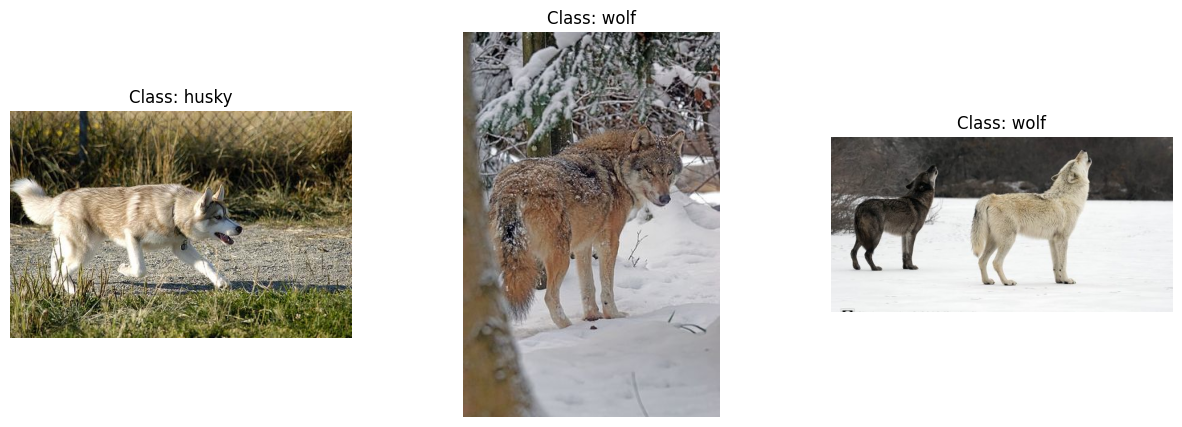

In [3]:
samples = df.sample(3)
# samples_without_background=df_without_background.sample(3)
# Plot the 3 images with their class labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, (idx, row) in enumerate(samples.iterrows()):
    img = mpimg.imread(row['image_path'])
    axes[i].imshow(img)
    axes[i].set_title(f"Class: {row['class']}")
    axes[i].axis('off')  # Hide axis

plt.show()


# b) Color Range Visualization  

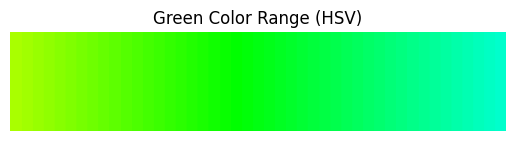

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the HSV range for green
lower_green = np.array([40, 40, 40], dtype=np.uint8)
upper_green = np.array([85, 255, 255], dtype=np.uint8)

# Create a gradient image in HSV within the green range
height, width = 100, 500  # Image size
gradient = np.zeros((height, width, 3), dtype=np.uint8)

# Fill with hue values from lower to upper green, with constant saturation and value
for i in range(width):
    hue = int(lower_green[0] + (upper_green[0] - lower_green[0]) * i / width)
    gradient[:, i, 0] = hue       # Set hue
    gradient[:, i, 1] = 255       # Set saturation to max for brightness
    gradient[:, i, 2] = 255       # Set value to max for brightness

# Convert to RGB for display
rgb_gradient = cv2.cvtColor(gradient, cv2.COLOR_HSV2RGB)

# Display the result
plt.imshow(rgb_gradient)
plt.title("Green Color Range (HSV)")
plt.axis('off')
plt.show()


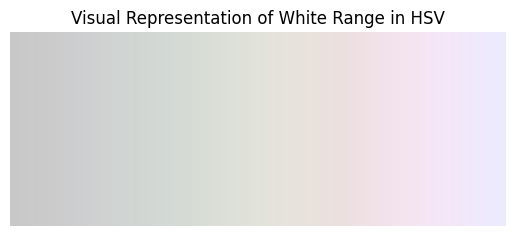

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_hsv_range(lower_bound, upper_bound):
    # Create a gradient image in HSV
    width, height = 256, 100
    gradient = np.zeros((height, width, 3), dtype=np.uint8)

    for x in range(width):
        # Interpolate between lower and upper bounds
        hue = lower_bound[0] + (upper_bound[0] - lower_bound[0]) * (x / width)
        saturation = lower_bound[1] + (upper_bound[1] - lower_bound[1]) * (x / width)
        value = lower_bound[2] + (upper_bound[2] - lower_bound[2]) * (x / width)

        gradient[:, x] = [hue, saturation, value]

    # Convert the HSV gradient to BGR for display
    gradient_bgr = cv2.cvtColor(gradient, cv2.COLOR_HSV2BGR)

    # Display the result using matplotlib
    plt.imshow(gradient_bgr)
    plt.axis('off')
    plt.title("Visual Representation of White Range in HSV")
    plt.show()

# Define the lower and upper bounds
lower_white = np.array([0, 0, 200])  # Lower boundary for white
upper_white = np.array([180, 20, 255])  # Upper boundary for white

# Visualize the range
visualize_hsv_range(lower_white, upper_white)


- We used this to be able to find the color ranges we will need to remove the background

# c) Background Removal

In [6]:
##### import cv2
import numpy as np
import matplotlib.pyplot as plt

def remove_background_husky(img):
    image = cv2.imread(img)

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for green color in HSV
    lower_green = np.array([40, 40, 40])    # Lower boundary for green (Hue, Saturation, Value)
    upper_green = np.array([85, 255, 255])  # Upper boundary for green

    # Create a mask to select green areas
    green_mask = cv2.inRange(hsv_image, lower_green, upper_green)

    # Change all green pixels to white
    image[green_mask > 0] = [0, 0, 0]


    return image
def remove_background_wolf(img):
    # Read the image
    image = cv2.imread(img)

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for white color in HSV
    lower_white = np.array([0, 0, 200])  # Lower boundary for white (Hue, Saturation, Value)
    upper_white = np.array([150, 25, 255])  # Upper boundary for white

    # Create a mask to select white areas
    white_mask = cv2.inRange(hsv_image, lower_white, upper_white)

    # Change all white pixels to green (BGR format for green)
    image[white_mask > 0] = [0, 0, 0]  # Set to green

    
    return image
# i=0
# for image in data['image_path']:
#     image_path=image
#     if(data['class'][i]=='husky'):
# #         result = remove_background_husky(image_path)
#           pass
#     else:
#           result = remove_background_wolf(image_path)
#         pass
#     i=i+1
    # Plot the original and background-removed images side-by-side
#     fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#     ax[0].imshow(cv2.imread(image_path)[:, :, ::-1])
#     ax[0].set_title("Original Image")
#     ax[0].axis('off')

#     ax[1].imshow(result)
#     ax[1].set_title("Image with Background Removed")
#     ax[1].axis('off')

#     plt.show()
# print(i)


# d) Splitting 

In [7]:
# Convert class labels to numeric (husky -> 0, wolf -> 1)
df['class'] = df['class'].apply(lambda x: 0 if x == 'husky' else 1)
# df_without_background['class'] = df_without_background['class'].apply(lambda x: 0 if x == 'husky' else 1)
# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")


Train size: 80, Test size: 20


# e) Data Preprocessing 

In [8]:
from PIL import Image
import numpy as np

class AnimalDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]

        # Load image and convert it to RGB
        image = Image.open(img_path).convert("RGB")
        if label == 0:
#             print("Label found:", label)
#               pass
              image = remove_background_husky(img_path)  # This should return a numpy array
        else:
            image = remove_background_wolf(img_path)
#             pass
            # Convert numpy array to PIL Image
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [9]:
from torchvision import transforms

class Replace255With0:
    def __call__(self, tensor):
        tensor[tensor == 1.0] = 0.0  # In PyTorch, 255 is scaled to 1.0
        return tensor
    
    
# Training transforms with more augmentation
train_transform_with_background = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(12),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_transform_without_background = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    Replace255With0(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Test transforms without augmentation
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# Datasets and DataLoaders
train_dataset = AnimalDataset(train_df, transform=train_transform_with_background)
# train_dataset_without_background = AnimalDataset(df_without_background, transform=train_transform_without_background)
test_dataset = AnimalDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# train_loader_without_background = DataLoader(train_dataset_without_background, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


- Colors the background black
- loading and preprocessing the images
- then intializes the dataloaders

Images shape: torch.Size([16, 3, 256, 256])
Labels: tensor([0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1])


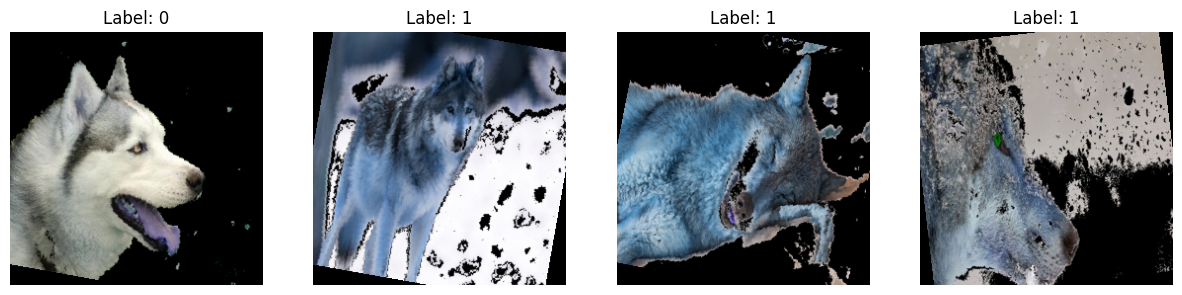

In [10]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader


# Function to display a batch of images and labels from the dataloader
def show_batch(loader):
    data_iter = iter(loader)  # Create an iterator
    images, labels = next(data_iter)  # Get the first batch
    print(f"Images shape: {images.shape}")  # E.g., torch.Size([4, 3, 256, 256])
    print(f"Labels: {labels}")  # Print the corresponding labels
    
    # Optionally display the images (requires matplotlib)
    import matplotlib.pyplot as plt
    grid_img = torch.permute(images, (0, 2, 3, 1))  # Move channels to last dimension
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        ax.imshow(grid_img[i])
        ax.set_title(f"Label: {labels[i]}")
        ax.axis('off')
    
    plt.show()

# Display a batch
show_batch(train_loader)
print(train_loader)


In [11]:
# total_images = sum(len(batch[0]) for batch in train_loader)
# print("Total images in train_loader:", total_images)

# f) CNN Model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNN(nn.Module):
    def __init__(self):
        super(ImprovedCNN, self).__init__()
        # Block 1: Conv -> BatchNorm -> ReLU -> Pool
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        # Block 2: Conv -> BatchNorm -> ReLU -> Pool
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Block 3: Conv -> BatchNorm -> ReLU -> Pool
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Global Adaptive Pooling to avoid hardcoding dimensions
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layers
        self.fc1 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.5)  # Dropout to reduce overfitting
        self.fc2 = nn.Linear(16, 2)  # Binary classification (husky vs. wolf)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Apply global adaptive pooling
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)  # Flatten

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = ImprovedCNN().to(device)
# print(model)


In [13]:
# import torch.optim as optim
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

# model.apply(weights_init)
# class_weights = torch.tensor([0.6, 0.6]).to(device)

# # Use weighted CrossEntropyLoss
# criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()  # Binary classification loss
# optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [14]:
def train(model, train_loader, test_loader, criterion, optimizer, epochs=10, scheduler=None):
    model.train()  # Ensure model is in training mode

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        if(epoch+1==epochs):
            print(f"Epoch [{epoch + 1}/{epochs}], Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%")

        # Validation loop
        model.eval()  # Set model to evaluation mode
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # No gradient computation in validation
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                # Calculate accuracy
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_test_loss = test_loss / len(test_loader)
        test_acc = 100 * correct / total
        if(epoch+1==epochs):
            print(f"Epoch [{epoch + 1}/{epochs}], Validation Loss: {avg_test_loss:.4f}, Validation Accuracy: {test_acc:.2f}%\n")

        # Step the scheduler if it is provided
        if scheduler:
            scheduler.step()

        model.train()# Set model back to training mode for the next epoch
    
    return avg_test_loss

# g) Hyperparameter Tuning

In [15]:
import torch.optim as optim
import torch.nn as nn

lr_values = [0.0001, 0.001, 0.005, 0.0005]
epoch_values = [15, 10, 20, 30]
best_loss = float('inf')
best_lr = 0
best_epochs = 0
best_model=ImprovedCNN().to(device)
for lr in lr_values:
    for epochs in epoch_values:
        model = ImprovedCNN().to(device)
        criterion = nn.CrossEntropyLoss() 
        optimizer = optim.Adam(model.parameters(), lr=lr)
        print(f"learning rate = {lr} epoch = {epochs}")

        test_loss = train(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)

        if test_loss < best_loss:
            best_loss = test_loss
            best_lr = lr
            best_epochs = epochs
            best_model=model

print(f"Best learning rate: {best_lr}")
print(f"Best number of epochs: {best_epochs}")
print(f"Best test loss: {best_loss}")


learning rate = 0.0001 epoch = 15
Epoch [15/15], Training Loss: 0.6004, Training Accuracy: 75.00%
Epoch [15/15], Validation Loss: 0.6053, Validation Accuracy: 80.00%

learning rate = 0.0001 epoch = 10
Epoch [10/10], Training Loss: 0.6260, Training Accuracy: 61.25%
Epoch [10/10], Validation Loss: 0.6876, Validation Accuracy: 50.00%

learning rate = 0.0001 epoch = 20
Epoch [20/20], Training Loss: 0.5643, Training Accuracy: 73.75%
Epoch [20/20], Validation Loss: 0.5537, Validation Accuracy: 85.00%

learning rate = 0.0001 epoch = 30
Epoch [30/30], Training Loss: 0.6309, Training Accuracy: 52.50%
Epoch [30/30], Validation Loss: 0.5885, Validation Accuracy: 50.00%

learning rate = 0.001 epoch = 15
Epoch [15/15], Training Loss: 0.4358, Training Accuracy: 76.25%
Epoch [15/15], Validation Loss: 0.4493, Validation Accuracy: 85.00%

learning rate = 0.001 epoch = 10
Epoch [10/10], Training Loss: 0.4720, Training Accuracy: 85.00%
Epoch [10/10], Validation Loss: 0.4935, Validation Accuracy: 65.00%



In [16]:
model = best_model
# model = ImprovedCNN().to(device)
# criterion = nn.CrossEntropyLoss() 
# optimizer = optim.Adam(model.parameters(), lr=best_lr)
# train(model, train_loader, test_loader, criterion, optimizer, epochs=best_epochs)

training with the best parameters

In [17]:
# from sklearn.model_selection import KFold
# import numpy as np

# # Convert class labels to numeric
# df['class'] = df['class'].apply(lambda x: 0 if x == 'husky' else 1)

# # Parameters
# num_folds = 5
# kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
# # K-Fold Cross Validation

# for fold, (train_index, val_index) in enumerate(kf.split(df)):
#     print(f"Fold {fold + 1}/{num_folds}")

#     # Split the data
#     train_df = df.iloc[train_index].reset_index(drop=True)
#     val_df = df.iloc[val_index].reset_index(drop=True)

#     # Create datasets
#     train_dataset = AnimalDataset(train_df, transform=train_transform_with_background)
#     val_dataset = AnimalDataset(val_df, transform=test_transform)

#     # Create data loaders
#     train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    
#     # Train the model
#     loss=train(model, train_loader, val_loader, criterion, optimizer, epochs=10)
#     # Optionally: Reset the model parameters if needed, or initialize a new model for each fold
# #     model = ImprovedCNN().to(device)  # Initialize a new model instance if needed


In [18]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

evaluate(model, test_loader)


Test Accuracy: 90.00%


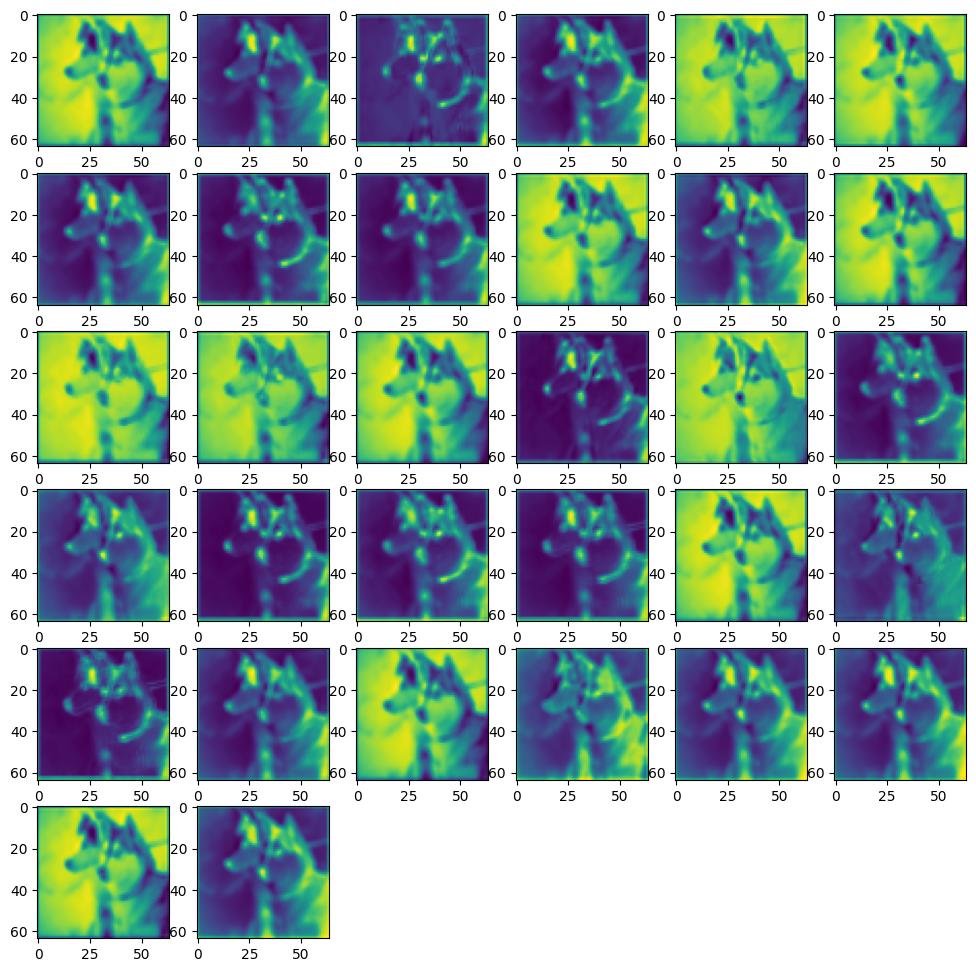

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np


# Hook to extract features
class FeatureExtractor:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.features = None
        
        # Register a forward hook to get the outputs of the specified layer
        self.hook = getattr(self.model, self.layer_name).register_forward_hook(self.get_features)

    def get_features(self, module, input, output):
        self.features = output.detach()

    def close(self):
        self.hook.remove()
        


# Define your transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])        

 # Function to load an image from the provided path
def load_image_from_path(image_path):
    if os.path.exists(image_path):
        return Image.open(image_path).convert('RGB')  # Open and convert to RGB
    else:
        raise FileNotFoundError(f"The file at {image_path} was not found.")
        
image_path = '/kaggle/input/testing/test/husky/Dog-Siberian_Husky-Two_.jpg'       
        
# Create the model and move it to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the feature extractor for the desired layer
layer_name = 'conv3'
feature_extractor = FeatureExtractor(model, layer_name)


image = load_image_from_path(image_path)

# Apply the transformations
your_image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

# Forward pass to get feature maps
_ = model(your_image_tensor)

# Extract feature maps
feature_maps = feature_extractor.features

# Visualizing the feature maps
# Normalize feature maps for better visualization
feature_maps = feature_maps.squeeze(0)  # Remove the batch dimension
num_features = feature_maps.size(0)
square = int(np.ceil(num_features ** 0.5))  # Calculate grid size

fig, axes = plt.subplots(square, square, figsize=(12, 12))
for i in range(square * square):
    if i < num_features:
        ax = axes[i // square, i % square]
        ax.imshow(feature_maps[i].cpu().numpy(), cmap='viridis')  # Move to CPU for plotting
    else:
        axes[i // square, i % square].axis('off')  # Hide empty subplots
plt.show()

# Close the hook
feature_extractor.close()

Activations shape: torch.Size([1, 32, 64, 64])
Weights shape: torch.Size([32])


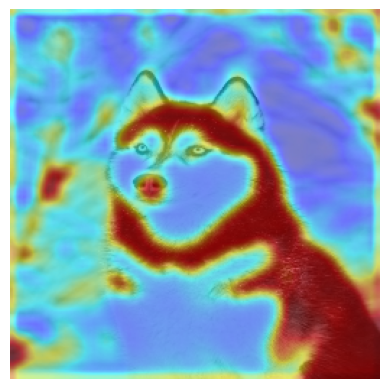

In [20]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

# Define the Grad-CAM function with resizing
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook to save gradients and activations
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, target_class):
        self.model.eval()
        output = self.model(x)

        # Zero gradients, backward pass on the target class
        self.model.zero_grad()
        target = output[0][target_class]
        target.backward()

        # Compute Grad-CAM
        weights = torch.mean(self.gradients, dim=(2, 3)).squeeze(0)  # Remove batch dimension

        # Debugging: Print shapes to identify mismatches (optional)
        print("Activations shape:", self.activations.shape)
        print("Weights shape:", weights.shape)

        # Calculate weighted combination of activations
        cam = torch.zeros(self.activations.shape[2:], dtype=torch.float32).to(x.device)
        for i, w in enumerate(weights):
            cam += w * self.activations[0, i, :, :]

        # Apply ReLU and normalize
        cam = F.relu(cam)

        # Resize the cam to match the input image dimensions
        cam = F.interpolate(cam.unsqueeze(0).unsqueeze(0), size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = cam - cam.min()
        cam = cam / cam.max()
        return cam



# Load and preprocess image
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

# Display the Grad-CAM heatmap overlayed on the image
def show_gradcam(image_path, cam):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (cam.shape[1], cam.shape[0]))

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img) / 255
    overlay = overlay / np.max(overlay)

    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

# Load model and image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_path = '/kaggle/input/testing/test/husky/8677b64.jpg'
image = load_image(image_path).to(device)

# Target class and layer
target_class = 0  # Adjust based on the class you want to visualize
target_layer = model.conv3  # Replace with your model's target layer

# Initialize Grad-CAM
grad_cam = GradCAM(model, target_layer)

# Generate and visualize Grad-CAM
cam = grad_cam(image, target_class)
show_gradcam(image_path, cam)


Prediction: Husky


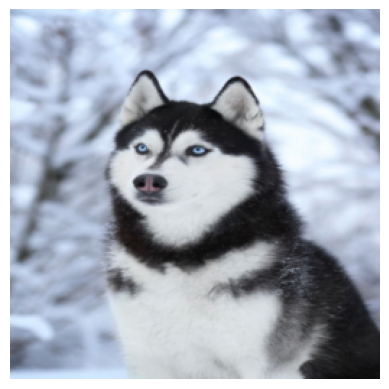

In [21]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load a test image
test = '/kaggle/input/testing/test/husky/8677b64.jpg'

# Define the test transformation
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    ])

# Open the image and apply transformations
image = Image.open(test).convert("RGB")
transformed_image = test_transform(image)

# Add a batch dimension to the image tensor
input_image = transformed_image.unsqueeze(0).to(device)  # Shape: [1, 3, 256, 256]

# Forward pass through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient computation for inference
    outputs = model(input_image)
    _, preds = torch.max(outputs, 1)

# Display the prediction
if preds.item() == 0:
    print('Prediction: Husky')
else:
    print('Prediction: Wolf')

# Convert the tensor back to a NumPy array for display
image_np = transformed_image.permute(1, 2, 0).numpy()  # [H, W, C]

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis
plt.show()


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.metrics import accuracy_score

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Uncomment normalization if it was applied during training
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def preprocess_images(test_path):
    x_test = []
    y_test = []
    husky=os.path.join(test_path,'husky')
    wolf=os.path.join(test_path,'wolf')
    
    for img in os.listdir(husky):
        print(img)
        image=os.path.join(husky,img)
        # Open the image and apply transformations
        image = Image.open(image).convert("RGB")
        transformed_image = test_transform(image)
        input_image = transformed_image.unsqueeze(0).to(device)
        x_test.append(input_image)
        y_test.append(0)
    for img in os.listdir(wolf):
        image=os.path.join(wolf,img)
        # Open the image and apply transformations
        image = Image.open(image).convert("RGB")
        transformed_image = test_transform(image)
        input_image = transformed_image.unsqueeze(0).to(device)
        x_test.append(input_image)
        y_test.append(1)
    
    return x_test, y_test

def make_predictions(x_test, model):
    
    # Prepare model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    predictions = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images in x_test:
            images= images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            predictions.append(preds)
    predictions = [tensor.cpu().numpy() for tensor in predictions]

    # Convert to a NumPy array
    predictions_array = np.array(predictions).flatten()
    print(predictions_array)
    return (predictions_array)


In [23]:
# Run testing
test_path = '/kaggle/input/testing/test'  # This will be replaced with the actual test path during grading
x_test, y_test = preprocess_images(test_path)  # Get test images and labels
y_pred = make_predictions(x_test, model)  # Pass x_test and model instance to make predictions
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

images (2).jpg
images (4).jpg
8677b64.jpg
Dog-Siberian_Husky-Two_.jpg
2301196.jpg
husky_snow.jpg
images (1).jpg
images (3).jpg
[0 1 0 0 0 0 0 0 0 1 0 0 0 1]
Test Accuracy: 0.6429


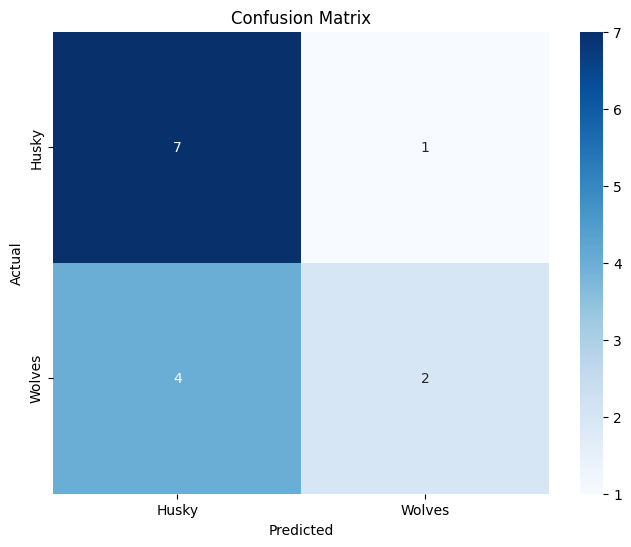

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Husky', 'Wolves'], yticklabels=['Husky', 'Wolves'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
